In [1]:
# THIS SOLVER USES THE GUROBI OPTIMIZATION SOFTWARE

from gurobipy import *

import shapely
import math
import pyproj
import sys
import fiona
import traceback
import json
sys.path.append('../../../alg')

import matplotlib.pyplot as plt, pandas as pd, geopandas as gpd, numpy as np
import distance_buffer as db, border_generators as bg, marching_army as ma, census_parser as cp, cmclp_solver as solver, data_generator as datagen, result_analyzer as ra

from rtree import index
from matplotlib import pyplot
from functools import partial
from shapely import geometry
from shapely.ops import transform
from descartes import PolygonPatch
from matplotlib.patches import Arc
from shapely.geometry import Point, Polygon, MultiPolygon, LineString
from scipy.stats import truncnorm

In [2]:
reload(ra)

<module 'result_analyzer' from '../../../alg/result_analyzer.pyc'>

In [57]:
reload(solver)

<module 'cmclp_solver' from '../../../alg/cmclp_solver.py'>

# Load data

In [4]:
bg_data_str = "../../../data/CA_WalnutCreek/CA_pop_bg/tabblock2010_06_pophu.shp"
places_data_str = "../../../data/CA_WalnutCreek/CA_places/tl_2010_06_place10.shp"
faces_data_str = "../../../data/CA_WalnutCreek/CTY_faces/tl_2010_06013_faces.shp"
countycode = '013'
placename = "Walnut Creek"

In [5]:
%%time
walnutcreek_data = cp.get_place_blockgroup_data(bg_data_str, places_data_str,
                                       faces_data_str, countycode, placename)

CPU times: user 1min 54s, sys: 2.02 s, total: 1min 56s
Wall time: 1min 55s


# 

In [6]:
#generate the randomly distributed demand points 
desired_num_demand_pts = 5000
west,south,east,north = walnutcreek_data['place_geom'].bounds
xrands, yrands = datagen.gen_n_random_coords([west,south,east,north], desired_num_demand_pts*3)

rnd_demand_pts = datagen.filter_random_pts_by_RoI(xrands,yrands,walnutcreek_data['place_geom'],walnutcreek_data['place_pop_data'])


In [7]:
tri_gridpts = datagen.gen_triangular_gridpts([west,south,east,north],250.0)

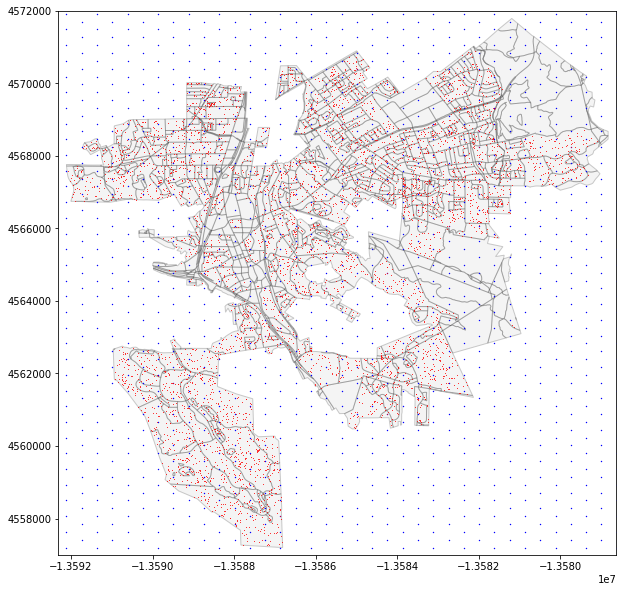

In [8]:
west,south,east,north = walnutcreek_data['place_geom'].bounds
fig1, ax1 = plt.subplots(figsize=(10,10))
for polygon in walnutcreek_data['place_geom']:
    patch = PolygonPatch(polygon, fc='#cccccc', ec='k', alpha=0.2, zorder=0)
    ax1.add_patch(patch)
ax1.scatter(x=tri_gridpts['x'], y=tri_gridpts['y'], s=2, c='b', linewidth=0, zorder=3)

#db.plot_radii(ax2, tmp_coords, 250.0, alpha=0.7, color="pink")
for gdf in rnd_demand_pts:
    if len(gdf)>0:
        ax1.scatter(x=gdf['x'], y=gdf['y'], s=1, c='r', linewidth=0, zorder=3)


ax1.set_xlim(west-200, east+200)
ax1.set_ylim(south-200, north+200)
ax1.axis('on')
#plt.savefig("grid_candpts_w_randpts_fixed.png",  dpi=192 * 10)
plt.show()

### get dmd wts + check for agreement

In [10]:
demand_wts = datagen.assign_pops_to_pts(rnd_demand_pts, walnutcreek_data['place_pop_data'])
datagen.test_pop_pt_agreement(walnutcreek_data['place_pop_data'], demand_wts, rnd_demand_pts) 

### get in temp form for solvers

In [11]:
tmp_facility_pts = datagen.gdf_to_list(tri_gridpts)
tmp_demand_pts = datagen.list_of_gdf_to_list_of_coords(rnd_demand_pts)
tmp_dmd_wts = solver.flatten_list_of_lists(demand_wts)

### run with P = 100

In [12]:
P = 100
S = 250.0

In [13]:
mclp_out_1 = solver.mclp_stages_elim(tmp_demand_pts,tmp_dmd_wts,tmp_facility_pts,P,S,stopcond=2)
    


In [14]:
cmclp_out_1 = solver.cmclp_stages_elim(tmp_demand_pts,tmp_dmd_wts,tmp_facility_pts,P,S,stopcond=2,relgaptol=0.000)


In [30]:
print len(tmp_demand_pts)
print len(tmp_dmd_wt)
print len(tmp_facility_pts)

5155
987
2438


In [38]:
len(tmp_facility_pts)

2438

In [15]:
selected_site_coords_m = ra.site_indexes_to_coords(mclp_out_1, tmp_facility_pts)
selected_site_coords_c = ra.site_indexes_to_coords(cmclp_out_1, tmp_facility_pts)

In [33]:
difoutput = solver.mclp_stages_elim(tmp_demand_pts,tmp_dmd_wts,tmp_facility_pts,P,S,stopcond=2)

In [63]:
errsitestry1 = trim_erroneous_sites(trimmedoutput, tmp_demand_pts, S)

In [55]:
trimmedoutput = []
for solndict in difoutput:
    if solndict['coveredpop'] >0:
        trimmedoutput.append(solndict)

In [56]:
print len(difoutput)
print len(trimmedoutput)

8
6


In [61]:
def trim_erroneous_sites(chosen_sites, dmdpts, S, tol=0.0):
    """
    
    Parameters
    ----------
      chosen_sites: list[dict{..., 'sites',...}] dict{int: tuple}
      dmdpts: list[tuple]
      S: float; service distance 

    Returns
    -------
      trimmed_chosen_sites: dict{int: tuple}
      
    Note:
    - since we solve MCLP/CMCLP with P, the final stage of our soln 
        may include extra chosen sites that don't actually cover anything
        in order to abide by the constraint; we want to eliminate them in
        our final results because they are erroneous 
    
    """
    last_stage_sites = chosen_sites[len(chosen_sites)-1]['sites']
    numdmdpts = len(dmdpts)
    numsites = len(last_stage_sites)
    maxdist = S+(S*tol)

    erroneouspts = {}
    for ind,coord in last_stage_sites.iteritems():
        for j in range(numdmdpts):
            if solver.distance(coord, dmdpts[j]) <= maxdist: #this is not an erroneous site; 
                break                               #it covers at least one dmd pt
            elif j == numdmdpts-1: #this means we looked thru all dmd pts, didnt find one that was covered
                erroneouspts[ind]=coord
            
    # now eliminate the erroneous pts from the soln
    for ind in erroneouspts.keys():
        if ind in last_stage_sites.keys():
            del last_stage_sites[ind]
    #return 

100

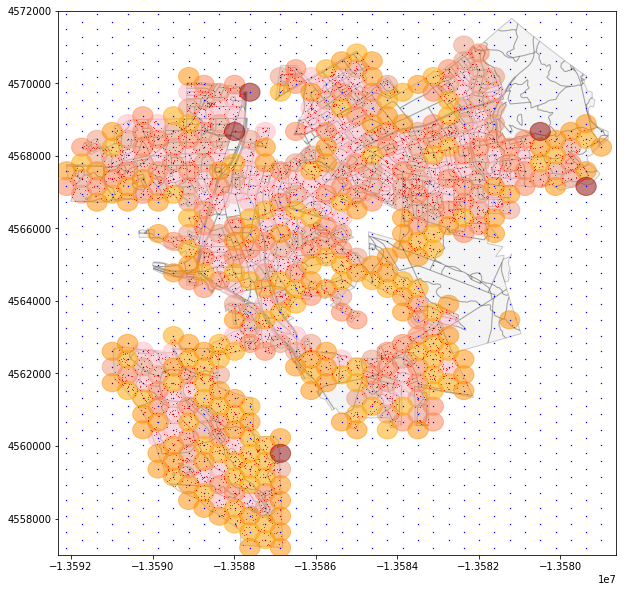

In [64]:
colorlist = ['lightpink','darksalmon','coral','orange','darkorange','darkred','darkorange', 'pink']

west,south,east,north = walnutcreek_data['place_geom'].bounds
fig3, ax3 = plt.subplots(figsize=(10,10))
for polygon in walnutcreek_data['place_geom']:
    patch = PolygonPatch(polygon, fc='#cccccc', ec='k', alpha=0.2, zorder=0)
    ax3.add_patch(patch)
ax3.scatter(x=tri_gridpts['x'], y=tri_gridpts['y'], s=2, c='b', linewidth=0, zorder=3)


for gdf in rnd_demand_pts:
    if len(gdf)>0:
        ax3.scatter(x=gdf['x'], y=gdf['y'], s=1, c='r', linewidth=0, zorder=3)
        
for i in range(0,len(trimmedoutput)):
#    db.plot_radii(ax3, selected_site_coords_c[i], S, alpha=0.5, color=colorlist[i])
    db.plot_radii(ax3, trimmedoutput[i]['sites'].values(), S, alpha=0.5, color=colorlist[i])
#db.plot_radii(ax3, errsitestry1.values(), S, alpha=0.5, color='black')
    
ax3.set_xlim(west-200, east+200)
ax3.set_ylim(south-200, north+200)
ax3.axis('on')
#plt.savefig("stage_soln_P100_S250.png",  dpi=192 * 10)
plt.show()